In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import tensorflow as tf
print(tf.__version__)
import gc
#from talos.model.layers import hidden_layers
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, LocallyConnected1D, Conv2D, Reshape, Dropout, MaxPool2D, Flatten
from keras.callbacks import ModelCheckpoint, History, EarlyStopping
from keras.activations import relu, elu, linear
from keras import backend as K
from keras import regularizers
from keras.datasets import mnist
from keras.utils import np_utils
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from PIL import Image
from tqdm import trange

plt.style.use('seaborn-darkgrid')
mpl.rcParams['figure.figsize'] = [10.0, 4.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 18

2.0.0


In [26]:
img = Image.open("../image.jpg")
img = img.crop((400, 200, 800, 600))

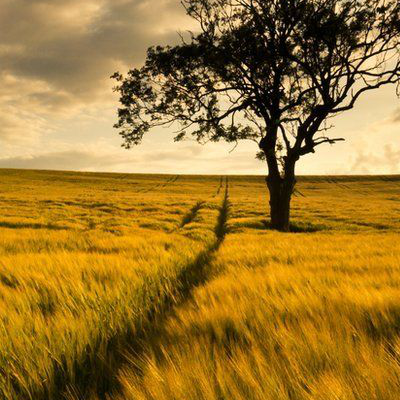

In [27]:
img

In [34]:
image_path = "../image.jpg"

In [28]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
import scipy
import argparse

from keras.applications import inception_v3
from keras import backend as K

# These are the names of the layers
# for which we try to maximize activation,
# as well as their weight in the final loss
# we try to maximize.
# You can tweak these setting to obtain new visual effects.
settings = {
    'features': {
        'mixed2': 0.2,
        'mixed3': 0.5,
        'mixed4': 2.,
        'mixed5': 1.5,
    },
}

In [29]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = load_img(image_path)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

K.set_learning_phase(0)

In [30]:
# Build the InceptionV3 network with our placeholder.
# The model will be loaded with pre-trained ImageNet weights.
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)
dream = model.input
print('Model loaded.')

87916544/87910968 [==============================] - 63s 1us/step
Model loaded.


In [31]:
# Get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Define the loss.
loss = K.variable(0.)
for layer_name in settings['features']:
    # Add the L2 norm of the features of a layer to the loss.
    if layer_name not in layer_dict:
        raise ValueError('Layer ' + layer_name + ' not found in model.')
    coeff = settings['features'][layer_name]
    x = layer_dict[layer_name].output
    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(x), 'float32'))
    if K.image_data_format() == 'channels_first':
        loss = loss + coeff * K.sum(K.square(x[:, :, 2: -2, 2: -2])) / scaling
    else:
        loss = loss + coeff * K.sum(K.square(x[:, 2: -2, 2: -2, :])) / scaling

# Compute the gradients of the dream wrt the loss.
grads = K.gradients(loss, dream)[0]
# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())

# Set up function to retrieve the value
# of the loss and gradients given an input image.
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

In [32]:
def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values


def resize_img(img, size):
    img = np.copy(img)
    if K.image_data_format() == 'channels_first':
        factors = (1, 1,
                   float(size[0]) / img.shape[2],
                   float(size[1]) / img.shape[3])
    else:
        factors = (1,
                   float(size[0]) / img.shape[1],
                   float(size[1]) / img.shape[2],
                   1)
    return scipy.ndimage.zoom(img, factors, order=1)


def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('..Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

In [36]:
"""Process:

- Load the original image.
- Define a number of processing scales (i.e. image shapes),
    from smallest to largest.
- Resize the original image to the smallest scale.
- For every scale, starting with the smallest (i.e. current one):
    - Run gradient ascent
    - Upscale image to the next scale
    - Reinject the detail that was lost at upscaling time
- Stop when we are back to the original size.

To obtain the detail lost during upscaling, we simply
take the original image, shrink it down, upscale it,
and compare the result to the (resized) original image.
"""


# Playing with these hyperparameters will also allow you to achieve new effects
step = 0.01  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 20  # Number of ascent steps per scale
max_loss = 10.

img = preprocess_image(image_path)
if K.image_data_format() == 'channels_first':
    original_shape = img.shape[2:]
else:
    original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)

save_img("../image_out.png", deprocess_image(np.copy(img)))

Processing image shape (331, 497)
..Loss value at 0 : 0.71728355
..Loss value at 1 : 0.9487866
..Loss value at 2 : 1.2384174
..Loss value at 3 : 1.5564498
..Loss value at 4 : 1.8785539
..Loss value at 5 : 2.2173328
..Loss value at 6 : 2.5752625
..Loss value at 7 : 2.909096
..Loss value at 8 : 3.2775598
..Loss value at 9 : 3.6565747
..Loss value at 10 : 4.012344
..Loss value at 11 : 4.355418
..Loss value at 12 : 4.704763
..Loss value at 13 : 5.0302024
..Loss value at 14 : 5.3695946
..Loss value at 15 : 5.693825
..Loss value at 16 : 6.0155573
..Loss value at 17 : 6.342368
..Loss value at 18 : 6.664223
..Loss value at 19 : 6.9372663
Processing image shape (463, 697)
..Loss value at 0 : 1.4099367
..Loss value at 1 : 2.2097366
..Loss value at 2 : 2.9183114
..Loss value at 3 : 3.5172708
..Loss value at 4 : 4.051858
..Loss value at 5 : 4.5344667
..Loss value at 6 : 5.0062375
..Loss value at 7 : 5.432406
..Loss value at 8 : 5.8421373
..Loss value at 9 : 6.212576
..Loss value at 10 : 6.5990133
